# Python Lecture (October 17th, 2023)

Today we are going to review some of the basic of data scraping, cleaning and model generation in Python. This should cover the foundational elements needed to complete your final projects, with each individual project likely requiring some further (independent) investigation.

We are going to mainly be working with the following website on live COVID data: https://www.worldometers.info/coronavirus/#countries

## Web scraping basics

#### What is web-scraping?

The process of extracting data and information from an available website. We want to glean the .html code to collect information for further anaylsis.

We are going to extract data from the following website:

https://www.worldometers.info/coronavirus/#countries

In particular, we are going to do the following with the displayed data:
1. Load the relevant Python packages
2. Define our scraping tools
3. Find and collect the data stored in the raw .html
4. Initial data exploration


### Preliminaries

Packages we use:

The first set are somewhat general and all purpose packages you will likely need for all programming in python to handle numerics and analysis.

The second set are for plotting which we will see many examples of later and that you have used in your homework assignments.

The last set we will go over as we use them, mainly used for retrieving data from the web in a usable format.

In [1]:
#-----General------#
import numpy as np
import pandas as pd
import os
import sys
import math
import random

#-----Plotting-----#
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns
# from pandas_profiling import ProfileReport

#-----Utility-----#
import itertools
import warnings
warnings.filterwarnings("ignore")
import re
import gc
from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen
from datetime import date, datetime

LOOK_AT = 5 # Controls how many bars the user can see in the bar graph
AT_LEAST = 50 # Controls what rank a country must be in terms of total cases to be shown on the bar graph

First, we need to set our target url and utilize the above packages to retrieve the raw contents.

In [2]:
fname = 'https://www.worldometers.info/coronavirus/#countries'

# A standard method is to specify your webbrowser as the user agent, but can also leave argument blank
req = Request(fname, headers={'User-Agent': 'Safari'})
# req = Request(fname, headers={'User-Agent': 'Mozilla/5.0'})

webpage = urlopen(req)
page_soup = soup(webpage, "html.parser")
today = datetime.now()
today_str = "%s %d, %d" % (date.today().strftime("%b"), today.day, today.year)
yesterday_str = "%s %d, %d" % (date.today().strftime("%b"), today.day-1, today.year)
clean = True # optional parameter we use to decide if we want to parse strings as ints

So, what do we currently have in the "page_soup" variable?


<!DOCTYPE html>

<!--[if IE 8]> <html lang="en" class="ie8"> <![endif]-->
<!--[if IE 9]> <html lang="en" class="ie9"> <![endif]-->
<!--[if !IE]><!-->
<html lang="en">
<!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>COVID - Coronavirus Statistics - Worldometer</title>
<meta content="Daily and weekly updated statistics tracking the number of COVID-19 cases, recovered, and deaths. Historical data with cumulative charts, graphs, and updates." name="description"/>
<!-- Favicon -->
<link href="/favicon/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/favicon/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
<link href="/favicon/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
<link href="/favicon/apple-icon-72x72.png" rel="apple-touch-icon" sizes="72x72"/>
<link href="/favicon/apple-icon-76x76.png" rel="apple-touch-icon
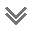

In [3]:
print(page_soup)

The entire html file, but we don't need all that and there's currently no way of seeing the actual data we are looking for.

#### Scraping Script
If clean is set to true, then the numerical data will be converted from a string to a float. We drop China in our analysis because of some inconsistent reporting / formatting for China when scraping the data. Let's use the Soup packages findAll command to locate the tables.

In [4]:
table1 = page_soup.findAll("table")
print(table1)

[<table class="table table-bordered table-hover main_table_countries" id="main_table_countries_today" style="width:100%;margin-top: 0px !important;display:none;">
<thead>
<tr>
<th width="1%">#</th>
<th width="100">Country,<br>Other</br></th>
<th width="20">Total<br>Cases</br></th>
<th width="30">New<br>Cases</br></th>
<th width="30">Total<br>Deaths</br></th>
<th width="30">New<br>Deaths</br></th>
<th width="30">Total<br>Recovered</br></th>
<th width="30">New<br>Recovered</br></th>
<th width="30">Active<br>Cases</br></th>
<th width="30">Serious,<br>Critical</br></th>
<th width="30">Tot Cases/<br/>1M pop</th>
<th width="30">Deaths/<br/>1M pop</th>
<th width="30">Total<br/>Tests</th>
<th width="30">Tests/<br/>
<nobr>1M pop</nobr>
</th>
<th width="30">Population</th>
<th style="display:none" width="30">Continent</th>
<th width="30">1 Case<br/>every X ppl</th><th width="30">1 Death<br/>every X ppl</th><th width="30">1 Test<br/>every X ppl</th>
<th width="30">New Cases/1M pop</th>
<th width=

Clearly this is more of the code than we actually want -- we have found **all** the tables but we really just want the displayed one. Let's inspect the html code to see the table id we actually want.

In [5]:
table = page_soup.findAll("table", {"id": "main_table_countries_today"})
# In your individual projects, you may need to access the prior day's data as well
# as todays. You can always insepct the webpage for this older data!

containers = table[0].findAll("tr", {"style": ""}) # tr in html = table row
# Basically, I want to first extract the row names (countries)

del containers[0] # remove the empty first column head

all_data = [] # variable where we will store the data
for country in containers: # iterate over the country names (rows)
    country_data = []
    country_container = country.findAll("td") # find all columns associated with this row
    # Now iterate over the columns

    if country_container[1].text == 'China':
        continue

    for i in range(1, len(country_container)):
        final_feature = country_container[i].text

        # Clean-up column names for easier usage later on (not necessary)
        if clean:
            if i != 1 and i != len(country_container)-1:
                final_feature = final_feature.replace(',', '')
                if final_feature.find('+') != -1:
                    final_feature = final_feature.replace('+', '')
                    final_feature = float(final_feature)
                elif final_feature.find('-') != -1:
                    final_feature = final_feature.replace('-', '')
                    final_feature = float(final_feature)*-1

        # Handle missing data
        if final_feature == 'N/A':
            final_feature = 0
        elif final_feature == '' or final_feature == ' ':
            final_feature = -1 # None
        country_data.append(final_feature)
    all_data.append(country_data)

A few preprocessing or cleaning steps we made here:
1. I removed any irregular characters from the data, ie. formatted strings to be numbers where possible, removed commas ...
2. If a column entry was read as not available, I replaced it by a 0 (think about the benefits and potential issues with doing this)
3. For the other other missing data, I replaced by a -1 (again, think about the benefits and issues)

Now we can cast our data to a Pandas dataframe to give ourselves more tools to work with and let's take a look at our reformatted data.

In [6]:
df = pd.DataFrame(all_data)
df = df.drop([i for i in range(15, len(all_data[0]))], axis=1) # Get rid of unnecessary columns
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,World,696656817,19345.0,6926687,45.0,668591161,24500.0,21138969,38058,89375,888.6,-1,-1,-1,All
1,USA,108944398,-1.0,1179271,-1.0,106806725,-1.0,958402,1457,325396,3522,1186371266,3543467,334805269,North America
2,India,44999561,-1.0,531930,-1.0,44467165,-1.0,466,0,31991,378,930797975,661721,1406631776,Asia
3,Germany,38514765,-1.0,176314,-1.0,38240600,-1.0,97851,0,459145,2102,122332384,1458359,83883596,Europe
4,Brazil,37849919,-1.0,706142,-1.0,36249161,-1.0,894616,0,175757,3279,63776166,296146,215353593,South America


In [7]:
column_labels = ["Country", "Total Cases", "New Cases", "Total Deaths", "New Deaths", "Total Recovered", "New Recovered", "Active Cases", "Serious/Critical",
                "Tot Cases/1M", "Deaths/1M", "Total Tests", "Tests/1M", "Population", "Continent"]
df.columns = column_labels
df.head()

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,Continent
0,World,696656817,19345.0,6926687,45.0,668591161,24500.0,21138969,38058,89375,888.6,-1,-1,-1,All
1,USA,108944398,-1.0,1179271,-1.0,106806725,-1.0,958402,1457,325396,3522,1186371266,3543467,334805269,North America
2,India,44999561,-1.0,531930,-1.0,44467165,-1.0,466,0,31991,378,930797975,661721,1406631776,Asia
3,Germany,38514765,-1.0,176314,-1.0,38240600,-1.0,97851,0,459145,2102,122332384,1458359,83883596,Europe
4,Brazil,37849919,-1.0,706142,-1.0,36249161,-1.0,894616,0,175757,3279,63776166,296146,215353593,South America


#### What Countries are not present in the Analysis?
For some reason, there are some countries that are not included when scraping the webpage.

In [8]:
country_labels = page_soup.findAll("a", {"class": "mt_a"})
# mt_a is an html tag that is used in this table to declare country names. We are
# searching for country names that are labeled in the html file but do not appear on the
# webpage

c_label = []
for country in country_labels:
    c_label.append(country.text)
c_label = set(c_label)

not_counted = []
sorted_countries = set(df['Country']) #Increase computational speed
for country in c_label:
    if country not in sorted_countries:
        not_counted.append(country)

print(not_counted)

['Sri Lanka', 'Ghana', 'Argentina', 'Syria', 'Niue', 'Taiwan', 'Greece', 'Cyprus', 'Cambodia', 'Peru', 'Eritrea', 'France', 'Falkland Islands', 'DPRK', 'Vatican City', 'Saint Kitts and Nevis', 'China', 'Ukraine', 'S. Korea', 'Western Sahara', 'Sudan', 'Denmark']


### Final Processing
Here, we will convert all the numerical data into np.int64 data type, and add some other features that may be particularly useful.

In [9]:
for label in df.columns:
    if label != 'Country' and label != 'Continent': # the variables which are non-numeric
        df[label] = pd.to_numeric(df[label])

In [10]:
df['%Inc Cases'] = df['New Cases']/df['Total Cases']*100
df['%Inc Deaths'] = df['New Deaths']/df['Total Deaths']*100
df['%Inc Recovered'] = df['New Recovered']/df['Total Recovered']*100

# Converting everything to percentages and putting the values in a new column

In [11]:
pd.options.display.max_rows = None
df

,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,Continent,%Inc Cases,%Inc Deaths,%Inc Recovered
0,World,696656817,19345.0,6926687,45.0,668591161,24500.0,21138969,38058,89375.0,888.6,-1,-1,-1,All,2.776834e-03,0.000650,3.664422e-03
1,USA,108944398,-1.0,1179271,-1.0,106806725,-1.0,958402,1457,325396.0,3522.0,1186371266,3543467,334805269,North America,-9.178994e-07,-0.000085,-9.362706e-07
2,India,44999561,-1.0,531930,-1.0,44467165,-1.0,466,0,31991.0,378.0,930797975,661721,1406631776,Asia,-2.222244e-06,-0.000188,-2.248850e-06
3,Germany,38514765,-1.0,176314,-1.0,38240600,-1.0,97851,0,459145.0,2102.0,122332384,1458359,83883596,Europe,-2.596407e-06,-0.000567,-2.615022e-06
4,Brazil,37849919,-1.0,706142,-1.0,36249161,-1.0,894616,0,175757.0,3279.0,63776166,296146,215353593,South America,-2.642014e-06,-0.000142,-2.758685e-06
5,Japan,33803572,-1.0,74694,-1.0,0,0.0,0,83,269169.0,595.0,100414883,799578,125584838,Asia,-2.958267e-06,-0.001339,NaN
6,Italy,26168412,-1.0,192013,-1.0,25810280,-1.0,166119,118,434238.0,3186.0,275228417,4567139,60262770,Europe,-3.821401e-06,-0.000521,-3.874425e-06
7,UK,24743787,-1.0,229765,-1.0,24500187,2160.0,13835,0,361234.0,3354.0,522526476,7628357,68497907,Europe,-4.041419e-06,-0.000435,8.816259e-03
8,Russia,23078812,16852.0,400145,43.0,22514317,15872.0,164350,0,158284.0,2744.0,273400000,1875095,145805947,Europe,7.301936e-02,0.010746,7.049736e-02
9,Turkey,17232066,-1.0,102174,-1.0,0,0.0,0,-1,201399.0,1194.0,162743369,1902052,85561976,Asia,-5.803135e-06,-0.000979,NaN


Now that we have finished processing the dataframe, let's check the basics of this set.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country           209 non-null    object 
 1   Total Cases       209 non-null    int64  
 2   New Cases         209 non-null    float64
 3   Total Deaths      209 non-null    int64  
 4   New Deaths        209 non-null    float64
 5   Total Recovered   209 non-null    int64  
 6   New Recovered     209 non-null    float64
 7   Active Cases      209 non-null    int64  
 8   Serious/Critical  209 non-null    int64  
 9   Tot Cases/1M      209 non-null    float64
 10  Deaths/1M         209 non-null    float64
 11  Total Tests       209 non-null    int64  
 12  Tests/1M          209 non-null    int64  
 13  Population        209 non-null    int64  
 14  Continent         209 non-null    object 
 15  %Inc Cases        209 non-null    float64
 16  %Inc Deaths       209 non-null    float64
 1

In [13]:
df.describe() # will conduct basic stastical analysis on all the variables

,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,%Inc Cases,%Inc Deaths,%Inc Recovered
count,2.090000e+02,209.000000,2.090000e+02,209.000000,2.090000e+02,209.000000,2.090000e+02,209.000000,209.000000,209.000000,2.090000e+02,2.090000e+02,2.090000e+02,209.000000,209.000000,189.000000
mean,9.418744e+06,276.741627,9.574098e+04,-0.330144,8.825431e+06,350.846890,2.368688e+05,391.114833,194329.313876,1247.388517,2.951248e+07,1.925299e+06,2.894050e+07,-0.008307,-1.195539,0.790340
std,6.840904e+07,2212.411239,6.820982e+05,5.407536,6.566252e+07,2637.981767,2.064383e+06,3713.281106,194621.333566,1255.578758,1.191002e+08,3.345340e+06,1.066763e+08,0.087010,14.834260,10.911163
min,8.000000e+01,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,0.000000e+00,-1.000000,381.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.250000,-100.000000,-50.000000
25%,2.733400e+04,-1.000000,1.940000e+02,-1.000000,1.318200e+04,-1.000000,6.500000e+01,-1.000000,23475.000000,177.000000,2.422070e+05,1.147710e+05,4.005160e+05,-0.003658,-0.444444,-0.004070
50%,2.091910e+05,-1.000000,1.971000e+03,-1.000000,1.192500e+05,-1.000000,9.470000e+02,1.000000,123910.000000,876.000000,1.621909e+06,7.398660e+05,5.323993e+06,-0.000434,-0.046318,-0.000385
75%,1.278286e+06,-1.000000,1.412200e+04,-1.000000,1.256151e+06,-1.000000,8.087000e+03,13.000000,312065.000000,1990.000000,1.100243e+07,2.072951e+06,1.920504e+07,-0.000067,-0.006136,-0.000056
max,6.966568e+08,19345.000000,6.926687e+06,45.000000,6.685912e+08,24500.000000,2.113897e+07,38058.000000,726625.000000,5626.000000,1.186371e+09,2.330212e+07,1.406632e+09,0.073019,100.000000,100.000000


## Basics of Plotting with Plotly
Now that we have a cleaned dataframe, we can do some basic visualizations of the given data + added features. These are just a few examples of basic plots that can be done, but I recommend you investigate both the Plotly and Seaborn package documentations for the range of possibilities.

In [14]:
cases_ser = df[["Total Recovered", "Active Cases", "Total Deaths"]].loc[0]
# Get the country data for active + recovered cases + deaths each as a row

cases_df = pd.DataFrame(cases_ser).reset_index() # 0-index the rows
cases_df.columns = ['Type', 'Total']
cases_df['Percentage'] = np.round(100*cases_df['Total']/np.sum(cases_df['Total']), 2)
cases_df['Virus'] = ['COVID-19' for i in range(len(cases_df))]

fig = px.bar(cases_df, x='Virus', y='Percentage', color='Type', hover_data=['Total'])
fig.update_layout(title={'text': f"Total Number of Cases, Recoveries, and Deaths on {yesterday_str}", 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Percentage", xaxis_title="")
fig.show(renderer="colab") # make sure to set your renderer to colab if running within your web browser

In [15]:
new_ser = df[["New Cases", "New Recovered", "New Deaths"]].loc[0]
new_df = pd.DataFrame(new_ser).reset_index()
new_df.columns = ['Type', 'Total']
new_df['Percentage'] = np.round(100*new_df['Total']/np.sum(new_df['Total']), 2)
new_df['Virus'] = ['COVID-19' for i in range(len(new_df))]

fig = px.bar(new_df, x='Virus', y='Percentage', color='Type', hover_data=['Total'])
fig.update_layout(title={'text': f"New Cases, Recoveries, and Deaths on {yesterday_str}", 'x': 0.5,
                         'xanchor': 'center', 'font': {'size': 20}}, yaxis_title="Percentage", xaxis_title="")
fig.show(renderer="colab")

In [16]:
continent_df = df.groupby('Continent').sum().drop('All')
continent_df = continent_df.reset_index()
continent_df

,Continent,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,New Recovered,Active Cases,Serious/Critical,Tot Cases/1M,Deaths/1M,Total Tests,Tests/1M,Population,%Inc Cases,%Inc Deaths,%Inc Recovered
0,Africa,12596667,-54.0,252225,-54.0,10731370,-50.0,397422,513,2487077.0,18359.0,107901428,10823164,1324052869,-0.220003,85.009743,-50.173909
1,Asia,169202760,24.0,1465189,-42.0,114644182,24.0,2016499,987,6186477.0,31304.0,2172699635,83174522,3102343533,-0.009740,-8.687658,-0.030127
2,Australia/Oceania,14677480,-19.0,30584,-19.0,14484435,-16.0,33571,37,4306824.0,9353.0,91667523,21256871,43468786,-1.420751,-204.672781,199.597734
3,Europe,195533022,19247.0,1749653,5.0,191653866,23606.0,1848019,871,16992902.0,117494.0,2300554303,178107502,622614811,0.185413,-10.580178,0.340385
4,North America,128724361,-38.0,1650066,-38.0,124264088,772.0,1903086,1813,8757560.0,58696.0,1324884773,99382157,598087045,-0.272397,-110.507133,-0.356316
5,South America,54469658,-11.0,1008773,-11.0,51554815,-9.0,1029049,1406,1705237.0,23721.0,170401515,9643187,357996462,-0.004207,-0.430898,-0.010774


### Model Fitting

Let's build a basic regression that finds the relationship between newly recovered individuals and serious/critical condition ones.

In [17]:
# Variable to predict with
predictor = pd.DataFrame(df, columns=["New Recovered"])

# Put the target variable in another DataFrame
target = pd.DataFrame(df, columns=["Serious/Critical"])

In [18]:
import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       Serious/Critical   R-squared (uncentered):                   0.814
Model:                            OLS   Adj. R-squared (uncentered):              0.813
Method:                 Least Squares   F-statistic:                              911.0
Date:                Tue, 17 Oct 2023   Prob (F-statistic):                    6.14e-78
Time:                        20:38:38   Log-Likelihood:                         -1839.3
No. Observations:                 209   AIC:                                      3681.
Df Residuals:                     208   BIC:                                      3684.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
New Recovered     1.2659      0.042     30.182      0.000       1.183       1.349
==============================================================================
Omnibus:                      363.048   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           122483.010
Skew:                          -8.633   Prob(JB):                         0.00
Kurtosis:                     120.333   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above, we see that the R^2 is 0.935, so the variables are highly correlated. How do we interpret that? Maybe countries with more patients recovering means more patients in overwhelmed hospitals, thus inadvertently more people reach critical condition due to a constrained hospital.

Unfortunately, with a very simple model that views data on such a high level, we cannot make a meaningful prediction on this relationship.

Now, let's instead try to predict missing data (a common practice when data is scarce or unreliable.

In [19]:
# Mask out certain data
num_rows = len(df)
mask = random.choices(range(num_rows), k=10)
train = df.index.difference(mask)

train_data = df.loc[train]
test_data  = df.iloc[mask]

# Restrict ourselves to just a few columns
missing_data = pd.DataFrame(df, columns=["New Recovered","Serious/Critical","Population"])

Let's first try replacing the values with a simple linear regression

In [20]:
# First build a regression using the available data
from sklearn.metrics import mean_squared_error

x_train = pd.DataFrame(train_data, columns=["New Recovered","Population"])
y_train = pd.DataFrame(train_data, columns=["Serious/Critical"])

x_test = pd.DataFrame(test_data, columns=["New Recovered","Population"])
y_test = pd.DataFrame(test_data, columns=["Serious/Critical"])

model = sm.OLS(y_train, x_train).fit()
y_pred = model.predict(x_test) # make the predictions by the model

rms = np.sqrt(mean_squared_error(y_test, y_pred)) # Compute the error of our model
print(rms)

150.3285555537848


Now we have a measure of the error from out model. But, the question remains, is this good? Can we do better? Maybe assuming a linear relationship is too strong, what about logistic?

In [21]:
# What about a Logistic Regression?
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression()
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

rms = np.sqrt(mean_squared_error(y_test, y_pred)) # Compute the error of our model
print(rms)

20.89976076418101


In [22]:
# Sometimes we do worse! Logistic relationship doesn't work. What else can we try?
from sklearn import svm
regr = svm.SVR()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

rms = np.sqrt(mean_squared_error(y_test, y_pred)) # Compute the error of our model
print(rms)

20.13196978521327


In [23]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

rms = np.sqrt(mean_squared_error(y_test, y_pred)) # Compute the error of our model
print(rms)

18.60323339990299


In [24]:
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,loss='squared_error').fit(x_train, y_train)

y_pred = est.predict(x_test)
rms = np.sqrt(mean_squared_error(y_test, y_pred)) # Compute the error of our model
print(rms)

25.918058836940247


From the above it's clear to see the major hurdle in exploratory data analysis is reading the data, cleaning it, and finally putting it into an easily manipulated form for your scripts. After that, the number of off the shelf packages for prediction is immense so there is freedom to try different models until you find one that works for your data.

